In [27]:
%matplotlib inline
import cloudpickle
import redis
import lz4.frame
import subprocess

import numpy as np
import time

import uproot
import uproot_methods
import numpy as np
import awkward

import pandas as pd

import concurrent.futures
from tqdm.auto import tqdm

import glob
import functools

import matplotlib.pyplot as plt

In [28]:
# functions to pickle and unpickle (to/from string) with lz4 compression
# note, cloudpickle requires same python version used locally and on worker!!
# this could be relaxed with a different pickle protocol in dumps(), but then life gets messier
def compress_and_dumps(obj):
    return lz4.frame.compress(cloudpickle.dumps(obj),compression_level=lz4.frame.COMPRESSIONLEVEL_MINHC)

def decompress_and_loads(obj):
    return cloudpickle.loads(lz4.frame.decompress(obj))

In [29]:
def get_met_hist(fname,entrystart=0,entrystop=None,bins=np.linspace(0,500,500)):
    """
    return 
    - event count considered
    - array of histogram bin counts for 1D MET distribution
    """
    f = uproot.open(fname)
    t = f["Events"]
    arr = t.array("MET_pt",entrystart=entrystart,entrystop=entrystop)
    nevents = len(arr)
    counts,_ = np.histogram(np.clip(arr,bins[0],bins[-1]),bins=bins)
    return (nevents,counts)

def get_mll_hist(fname,entrystart=0,entrystop=None,bins=np.linspace(0,500,1000)):
    """
    return 
    - event count considered
    - array of histogram bin counts for m(mumu) for nmu==2 events
    """
    f = uproot.open(fname)
    t = f["Events"]
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(
            ["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],
            outputtype=tuple,
            namedecode="ascii",
            entrystart=entrystart,
            entrystop=entrystop,
        ),
    )
    nevents = len(p4)
    pairs = p4[p4.counts==2]
    mll = (pairs[:,0]+pairs[:,1]).mass
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return (nevents,counts)

In [30]:
# Either hardcode `fullurl` here to the proper redis url, or put it `secret.txt`

# fullurl = "redis://:blah@ec2-1-2-3-4.us-west-1.compute.amazonaws.com:6379"
fullurl = open("secret.txt").read().strip()
r = redis.Redis.from_url(fullurl)

In [31]:
# queue name relies on username to avoid clashes
user = os.getenv("USER")
qname_results = user+":results"
qname_tasks = user+":tasks"

In [32]:
df = pd.DataFrame(r.client_list()).query("flags!='N'")[["addr","name","age","id","idle"]]
print(" {} total workers ".format(df.shape[0]).center(50,"="))
df.head()

================ 10 total workers ================


,addr,name,age,id,idle
0,169.228.132.178:11174,namin__sdsc-79.t2.ucsd.edu__mytask1__10183323.0,35,1184,35
1,169.228.131.240:53810,namin__cabinet-0-0-14.t2.ucsd.edu__mytask1__10...,24,1190,23
2,169.228.131.44:57798,namin__cabinet-5-5-25.t2.ucsd.edu__mytask1__10...,31,1185,31
4,169.228.131.240:53776,namin__cabinet-0-0-14.t2.ucsd.edu__mytask1__10...,25,1186,25
5,169.228.131.240:53778,namin__cabinet-0-0-14.t2.ucsd.edu__mytask1__10...,25,1187,25


In [33]:
@functools.lru_cache(maxsize=128)
def get_chunking(filelist, chunksize, treename="Events", workers=1):
    """
    Return 2-tuple of
    - chunks: triplets of (filename,entrystart,entrystop) calculated with input `chunksize` and `filelist`
    - total_nevents: total event count over `filelist`
    """
    print("Recomputing")
    chunks = []
    executor = None if len(filelist) < 5 else concurrent.futures.ThreadPoolExecutor(workers)
    nevents = 0
    for fn, nentries in uproot.numentries(filelist, treename, total=False, executor=executor,).items():
        nevents += nentries
        for index in range(nentries // chunksize + 1):
            chunks.append((fn, chunksize*index, chunksize*(index+1)))
    return chunks,nevents

In [34]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run*/*.root"))
# fnames = sorted(glob.glob("/hadoop/cms/store/user/namin/nanoaod/JetHT__Run*/*.root"))

# For testing, just 50 files (doublemu has ~130 total)
fnames = fnames[:50]

chunks, total_nevents = get_chunking(tuple(fnames),int(0.5e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

Recomputing
173 chunks of 50 files, with a total of 7.5548e+07 events
CPU times: user 5.41 s, sys: 323 ms, total: 5.73 s
Wall time: 12.2 s


In [35]:
# Flush old results/tasks in case we quit before consuming all of them
r.delete(qname_results,qname_tasks)

t0 = time.time()

# Plot MET branch (fast) or dimuon mass (slower)?
do_met = True
# do_met = False

if do_met:
    # 1D histogram of MET
    bins = np.linspace(0,500,500)
    f = get_met_hist
else:
    # 1D histogram of dimuon invariant mass
    # log spaced binning for cleaner low mass resonances
    bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
    f = get_mll_hist
    
# Push all task function/args to the broker
# Use a pipeline to put all lpushes into a single transfer
# (~500 lpushes takes a few seconds otherwise)
print("Start pushing tasks to broker")
pipe = r.pipeline()
for fname,entrystart,entrystop in chunks:
    pipe.lpush(qname_tasks,compress_and_dumps([
        functools.partial(f,bins=bins,entrystart=entrystart,entrystop=entrystop),
        fname
    ]))
pipe.execute()
print("Done pushing tasks to broker")

# Read results from broker
results = []
bar = tqdm(total=total_nevents,unit_scale=True,unit="event")
batchsize = 1+(len(chunks)//25) # batch size for pipeline
while len(results) < len(chunks):
    pipe = r.pipeline()
    for _ in range(batchsize):
        pipe.brpop(qname_results)
    for pc in pipe.execute():
        if pc is None: continue
        key,res_raw = pc
        meta,(nevents,counts) = decompress_and_loads(res_raw)
        results.append(dict(
            fname=meta["args"],
            nevents=nevents,
            counts=counts,
            client=meta["client_name"],
            elapsed=meta["elapsed"]
        ))
        bar.update(nevents)
t1 = time.time()
print("{:.5g} events in {:.2f}s @ {:.2f}MHz".format(total_nevents,t1-t0,1.0e-6*total_nevents/(t1-t0)))

Start pushing tasks to broker
Done pushing tasks to broker


7.5548e+07 events in 40.52s @ 1.86MHz


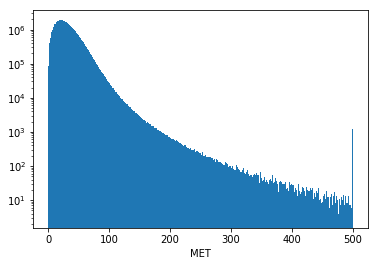

In [36]:
# sum up the histograms
counts = sum([x["counts"] for x in results])
if do_met:
    centers = 0.5*(bins[1:]+bins[:-1])
    fig,ax = plt.subplots()
    ax.hist(centers,weights=counts,bins=bins);
    ax.set_yscale("log")
    ax.set_xlabel("MET")
else:
    print("{:.5g} total muons".format(counts.sum()))
    # log spaced bin centers (matching the inputs)
    centers = np.power(10.,0.5*(np.log10(bins[:-1])+np.log10(bins[1:])))
    fig,ax = plt.subplots()
    ax.hist(centers,weights=counts,bins=bins);
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Invariant mass")

In [37]:
r.info("all")

{'active_defrag_hits': 0,
 'active_defrag_key_hits': 0,
 'active_defrag_key_misses': 0,
 'active_defrag_misses': 0,
 'active_defrag_running': 0,
 'allocator_active': 1134592,
 'allocator_allocated': 806376,
 'allocator_frag_bytes': 328216,
 'allocator_frag_ratio': 1.41,
 'allocator_resident': 5652480,
 'allocator_rss_bytes': 4517888,
 'allocator_rss_ratio': 4.98,
 'aof_current_rewrite_time_sec': -1,
 'aof_enabled': 0,
 'aof_last_bgrewrite_status': 'ok',
 'aof_last_cow_size': 0,
 'aof_last_rewrite_time_sec': -1,
 'aof_last_write_status': 'ok',
 'aof_rewrite_in_progress': 0,
 'aof_rewrite_scheduled': 0,
 'arch_bits': 64,
 'atomicvar_api': 'atomic-builtin',
 'blocked_clients': 10,
 'client_recent_max_input_buffer': 2,
 'client_recent_max_output_buffer': 0,
 'cluster_enabled': 0,
 'cmdstat_auth': {'calls': 1286, 'usec': 3213, 'usec_per_call': 2.5},
 'cmdstat_brpop': {'calls': 654227, 'usec': 645858, 'usec_per_call': 0.99},
 'cmdstat_client': {'calls': 1352, 'usec': 27935, 'usec_per_call': 

In [38]:
df = pd.DataFrame(results).drop(["counts"],axis=1)
df["rate"] = df["nevents"]/df["elapsed"]
# Stats for nodes we ran on. Show slowest nodes (Hz) at the top.
df.groupby(df.client.str.split(".",1).str[0])["rate"].mean().sort_values()

client
namin__cabinet-5-5-25     160345.740239
namin__cabinet-11-11-8    171825.527479
namin__cabinet-0-0-14     189171.071326
namin__sdsc-79            247277.851738
Name: rate, dtype: float64